In [1]:
import os.path
import sys

from imageio import imread
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymongo

sys.path.append(r'C:\Users\hornu\OneDrive\Documents\repos\flags\scripts\image-scripts')

from plot_utils import plot_colour_histogram

In [2]:
mg_client = pymongo.MongoClient("mongodb://localhost:27017/")
db_flag = mg_client.get_database('flags')
db_flag.list_collection_names()

['countries', 'flags', 'raw_countries']

In [3]:
countries =  db_flag.countries.find(
                      {}, 
                       {'_id' : 0,
                        'code' : 1, 
                        'data.adapted': 1
                       }
                    )

countries = list(countries)

Retrieve flag histogram and merge it into the country dictionary. The now surplus `data` field is then removed.

In [4]:
for country in countries:
    res = db_flag.flags.find_one({
                                    'code' : country['code']
                                    }, 
                                   {
                                       'data.colours' : 1,
                                   '_id' : 0
                                   }
                                )
    
    country.update({'histo' : res['data']['colours']})
    country.update({'adapted' : country['data']['adapted']})
    _ = country.pop('data', None)

The dictionary is then loaded in to a pandas dataframe:

In [5]:
df_countries = pd.DataFrame(countries)

df_countries.head()

,adapted,code,histo
0,2004,AF,"{'0-0-0': 0.3122534979423868, '0-122-54': 0.31..."
1,1912,AL,"{'255-0-0': 0.8626316812439262, '0-0-0': 0.137..."
2,1962,DZ,"{'255-255-255': 0.4769744855967078, '0-98-51':..."
3,1993,AD,"{'208-16-58': 0.32, '0-24-168': 0.32, '254-223..."
4,2003,AO,"{'204-9-47': 0.48061234567901234, '0-0-0': 0.4..."


## Statistics

### Number of colours in a flag

First we calculate the number of colours in each flag:

In [6]:
df_countries['n_colours'] = df_countries['histo'].apply(lambda x: len(x))

To gauge extent of skewedness of the number of colours the ten flags with most colours are identified:

In [7]:
df_countries.nlargest(10, 'n_colours')

,adapted,code,histo,n_colours
17,1981,BZ,"{'0-63-135': 0.5359242155121373, '255-255-255'...",365
49,1960,EC,"{'255-221-0': 0.47388117283950615, '237-28-36'...",345
66,1996,GT,"{'73-151-208': 0.6666666666666666, '255-255-25...",208
122,1908,NI,"{'0-103-198': 0.6666666666666666, '255-255-255...",139
108,1968,MX,"{'0-104-71': 0.3333333333333333, '206-17-38': ...",127
51,1912,SV,"{'0-71-171': 0.6666666666666666, '255-255-255'...",79
48,1844,DO,"{'206-17-38': 0.35090041152263374, '0-45-98': ...",13
146,1862,SM,"{'255-255-255': 0.4501888888888889, '94-182-22...",13
161,1981,ES,"{'198-11-30': 0.496, '255-196-0': 0.4443102427...",13
56,1970,FJ,"{'104-191-229': 0.6523061728395062, '255-255-2...",10


It is an interesting find! The top six countries are located in Meso and south America. All of them have more than fifteen colours. 

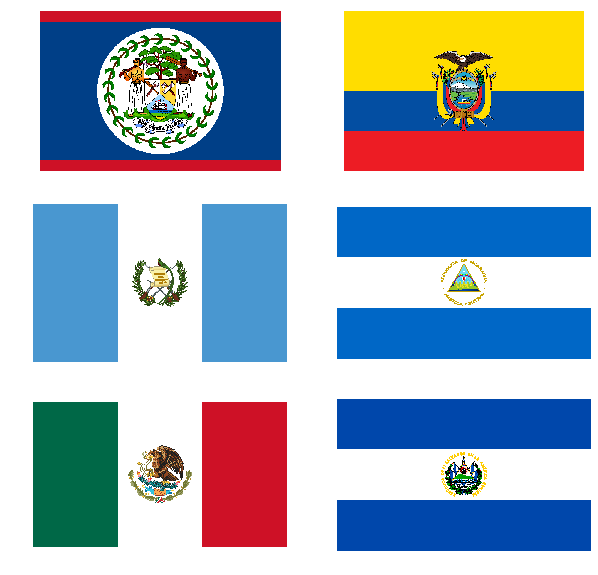

In [8]:
# TO SKIP -- plot setup

paths = [
         r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images\png\belize.png',
         r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images\png\ecuador.png',
         r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images\png\guatemala.png',
         r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images\png\nicaragua.png',
         r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images\png\mexico.png',
         r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images\png\el salvador.png'
        ]

fig, axes = plt.subplots(3,2)
fig.set_size_inches(10, 10)

for ax, path in zip(axes.flat, paths):
    image = imread(path)
    ax.imshow(image)
    ax.axis('off')
    
plt.show()

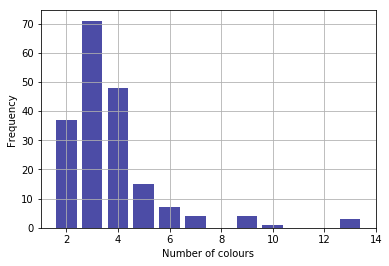

In [9]:
# TO SKIP -- plot setup

a = df_countries.groupby(['n_colours']).size()
n_col, n_col_freq = a.index.values, a.values

fig, ax = plt.subplots(1,1)
ax.bar(n_col[:-6], n_col_freq[:-6], color = 'navy', alpha = 0.7)
ax.grid(True)
ax.set_xlabel("Number of colours")
ax.set_ylabel("Frequency")
plt.show()

In [29]:
from collections import Counter
from itertools import chain, groupby

In [46]:
# count colours without weight
colour_counter = Counter(chain(*(x['histo'].keys() for x in countries)))
colours, counts = zip(*colour_counter.most_common())

str_to_np_rgb = lambda x: np.array([int(y) for y in x.split('-')])
colours = np.array([str_to_np_rgb(x) for x in colours]) 
counts = np.array(counts) / sum(colour_counter.values())

# count colours with weight
w_dict = {}
for c, w in chain.from_iterable((x['histo'].items() for x in countries)):
    if c in w_dict:
        w_dict[c] += w
    else:
        w_dict.update({c:w})

colours_w, counts_w = zip(*sorted(w_dict.items(), key = lambda x: x[1], reverse = True))
colours_w  = np.array([str_to_np_rgb(x) for x in colours_w]) 
counts_w = np.array(counts_w) / sum(counts_w)

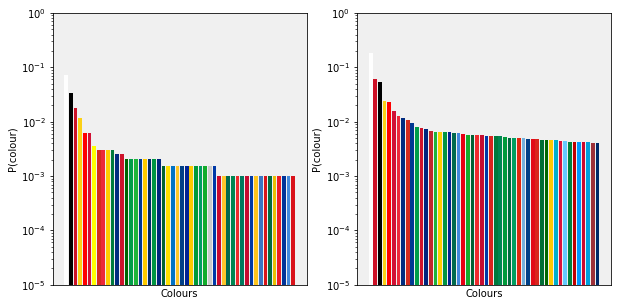

In [49]:
# TO SKIP -- plot setup

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

plot_colour_histogram(colours, counts, axes[0], n_show = 50)
plot_colour_histogram(colours_w, counts_w, axes[1], n_show = 50)

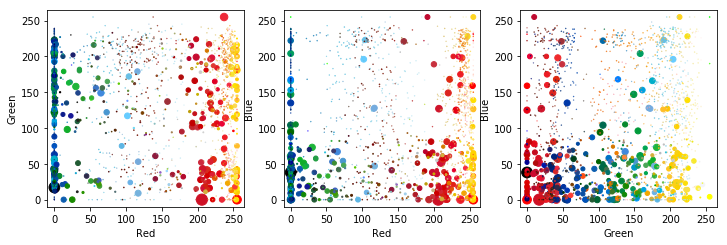

In [86]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 5)

axes[0].scatter(colours_w[:,0], colours[:,1], c = colours_w / 255.0, s = np.sqrt(counts_w)*500)
axes[1].scatter(colours_w[:,0], colours[:,2], c = colours_w / 255.0, s = np.sqrt(counts_w)*500)
axes[2].scatter(colours_w[:,1], colours[:,2], c = colours_w / 255.0, s = np.sqrt(counts_w)*500)

x_l = -10; x_u = 265;
axes[0].set_xlim((x_l, x_u)); axes[1].set_xlim((x_l, x_u)); axes[2].set_xlim((x_l, x_u));
axes[0].set_ylim((x_l, x_u)); axes[1].set_ylim((x_l, x_u)); axes[2].set_ylim((x_l, x_u));
axes[0].set_aspect('equal'); axes[1].set_aspect('equal'); axes[2].set_aspect('equal');

axes[0].set_xlabel("Red"); axes[1].set_xlabel("Red"); axes[2].set_xlabel("Green");
axes[0].set_ylabel("Green"); axes[1].set_ylabel("Blue"); axes[2].set_ylabel("Blue");

In [77]:
from sklearn.cluster import 

array([65.80008997,  5.26382115, 30.13063738])